In [1]:
# IMPORT THE REQUIRED LIBRARIES

from typing import NamedTuple
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        Metrics,
                        component, 
                        OutputPath, 
                        InputPath)

from kfp.v2 import compiler
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
from google_cloud_pipeline_components import aiplatform as gcc_aip
from datetime import datetime

In [2]:
# SET UP GLOBAL VARIABLES

PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="europe-west2"

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]

# Set bucket name
BUCKET_NAME="gs://"+PROJECT_ID+"-test"

# Create bucket
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root_test/"
PIPELINE_ROOT

env: PATH=/opt/conda/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/home/jupyter/.local/bin


'gs://gb-lab-us-binders-15-test/pipeline_root_test/'

In [3]:
# Custom base image created using docker

IMAGE_NAME = "training"
BASE_IMAGE = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/test/{IMAGE_NAME}"

## Read the Dataset

In [4]:
@component(
    base_image="europe-west2-docker.pkg.dev/gb-lab-us-binders-15/test/training",
    output_component_file="get_data.yaml"
)

def get_houseprice_data(
    filepath: str,
    dataset_train: Output[Dataset],
    dataset_valid: Output[Dataset],
    dataset_test: Output[Dataset]
):
    
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    
    df_train = pd.read_csv(filepath + '/train.csv')
    df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)
    df_test = pd.read_csv(filepath + '/test.csv')
   
    df_train.to_csv(dataset_train.path+'.csv', index=False, encoding='utf-8-sig')
    df_valid.to_csv(dataset_valid.path+'.csv', index=False, encoding='utf-8-sig')
    df_test.to_csv(dataset_test.path+'.csv', index=False, encoding='utf-8-sig')

## Feature Engineering and Feature Selection

In [5]:
@component(
    base_image=BASE_IMAGE,
    output_component_file="feature_eng_and_selection.yaml"
)


def feat_engineering_and_selection(
    train_df: Input[Dataset],
    valid_df: Input[Dataset],
    test_df: Input[Dataset],
    train_feat_eng_df: Output[Dataset],
    valid_feat_eng_df: Output[Dataset],
    test_feat_eng_df: Output[Dataset]
):
    
    import pandas as pd
    import numpy as np
    from src.feat_eng import MissingValueImputer, RareCatLabelsHandler, CustomOneHotEncoder, save_feat_eng_df
    from src.feat_eng import feat_eng_pipeline1
    from src.feat_selection import FeatureSelector    
    from sklearn.pipeline import Pipeline
    
    train_df = pd.read_csv(train_df.path+'.csv')
    valid_df = pd.read_csv(valid_df.path+'.csv')
    test_df = pd.read_csv(test_df.path+'.csv')
    
    X_train = train_df.drop(['Id', 'SalePrice'], axis=1).copy()
    y_train = train_df['SalePrice']
    
    X_valid = valid_df.drop(['Id', 'SalePrice'], axis=1).copy()
    y_valid = valid_df['SalePrice']

    X_test = test_df.drop('Id', axis=1).copy()
    
    # feat_eng_pipeline1() creates a copy of the df, converts to correct dtype, \
    # subtracts YearSold from temporal features and cosine transforms cyclic features.
    X_train_eng = feat_eng_pipeline1(X_train)
    X_valid_eng = feat_eng_pipeline1(X_valid)
    X_test_eng = feat_eng_pipeline1(X_test)
    
    
    # For numerical columns, we pass all of them (not just the ones with missing valuees)
    # As IterativeImputer models each feature with missing values as a function of all other features
    numeric_features = list(X_train.select_dtypes(np.number).columns)
    
    # For some columns, NaN values, instead of indicating the absence of data, have an actual meaning such as No Alley
    # Therefore, we will replace such NaN values by None
    # We go through each categorical col. with missing values one by one to identify the ones where NaN values mean something
    cat_features1 = ['Alley',
                     'BsmtQual',
                     'BsmtCond',
                     'BsmtExposure',
                     'BsmtFinType1',
                     'BsmtFinType2',
                     'FireplaceQu',
                     'GarageType',
                     'GarageFinish',
                     'GarageQual',
                     'GarageCond',
                     'PoolQC',
                     'Fence',
                     'MiscFeature'
                    ]
    
    # For categorical variables where NaN values just indicate the absence of data, we will replace with the Mode of the column
    cat_features2 = ['MSZoning',
                    'Utilities',
                    'Exterior1st',
                    'Exterior2nd',
                    'MasVnrType',
                    'Electrical',
                    'KitchenQual',
                    'Functional',
                    'SaleType'
                   ]
    
    cat_features = X_train.select_dtypes(object).columns.tolist()
    
    
    # Define the pipeline
    pipe = Pipeline([
    ('imputer', MissingValueImputer(numeric_features, cat_features1, cat_features2)), 
    ('rarecathandler', RareCatLabelsHandler(cat_features)), 
    ('encoder', CustomOneHotEncoder(cat_features)),
    ('featureselector', FeatureSelector())
    ])
    
    
    X_train_eng = pipe.fit_transform(X_train_eng, y=y_train)
    X_valid_eng = pipe.transform(X_valid_eng)
    X_test_eng = pipe.transform(X_test_eng)
    
    save_feat_eng_df(train_feat_eng_df.path+'.csv', X_train_eng, target=y_train)
    save_feat_eng_df(valid_feat_eng_df.path+'.csv', X_valid_eng, target=y_valid)
    save_feat_eng_df(test_feat_eng_df.path+'.csv', X_test_eng)
    

## Train the Model

In [6]:
@component(
    base_image=BASE_IMAGE,
    output_component_file="model_training.yaml"
)

def train_houseprice(
    train_set_feat_eng: Input[Dataset],
    valid_set_feat_eng: Input[Dataset],
    test_set_feat_eng: Input[Dataset],
    model: Output[Model], 
):
    
    import pandas as pd
    import pickle
    from src.train import HousePriceModel

    train_data = pd.read_csv(train_set_feat_eng.path+'.csv')
    valid_data = pd.read_csv(valid_set_feat_eng.path+'.csv')
    test_data = pd.read_csv(test_set_feat_eng.path+'.csv')
    
    house_price_model = HousePriceModel(train_data.copy(),
                                        valid_data.copy(),
                                        target='SalePrice',
                                        n_kfold_splits=2,
                                        n_trials=10,
                                        random_state=42)
    
    house_price_model.train()
    
    model.metadata["framework"] = "xgboost"
    file_name = model.path + f".pkl"
    with open(file_name, 'wb') as file:  
        pickle.dump(house_price_model, file)

## Evaluate the Model

In [7]:
@component(
    base_image=BASE_IMAGE,
    output_component_file="model_evaluation.yaml"
)

def evaluate_houseprice(
    houseprice_model: Input[Model], 
    thresholds_dict: dict,
    metrics: Output[Metrics],
    kpi: Output[Metrics]
) -> NamedTuple("output", [("deploy", str)]):
    
    import numpy as np
    import pickle
    from src.model_validation import plot_cross_validated_metrics, plot_lorenz_curves
    
    def threshold_check(val_train, val_test):
        cond = "false"
        if val_test > val_train and np.abs(val_test - val_train) < 1:
            cond = "true"
        return cond
    
    file_name = houseprice_model.path + f".pkl"
    with open(file_name, 'rb') as file:  
        model = pickle.load(file)
    
    cv_results_dict = model.results_dict
    
    plot_cross_validated_metrics(cv_results_dict)
    plot_lorenz_curves(cv_results_dict)
    
    
    train_neg_mean_gamma_dev, test_neg_mean_gamma_dev = cv_results_dict['train_neg_mean_gamma_deviance'], cv_results_dict['test_neg_mean_gamma_deviance']
    train_r2_score, test_r2_score = cv_results_dict['train_r2'], cv_results_dict['test_r2']
    
    check1 = []
    for i, j in train_neg_mean_gamma_dev, test_neg_mean_gamma_dev:
        check1.append(threshold_check(j, i)) # WE WANT THE TEST GAMMA DEVIANCE TO BE GREATER THAN TRAIN (and the output gamma deviance values are positive)
       
    check2 = []
    for i, j in train_r2_score, test_r2_score:
        if all([x > 0 for x in [i, j]]) and all([x > thresholds_dict['r2_score'] for x in [i,j]]): # R2_SCORES SHOULD BE POSITIVE AND GREATER THAN THRESHOLD (e.g. if threhold=0.8, it means model explains more than 80% of the variance in data)
            check2.append(threshold_check(i, j)) # WE WANT THE TEST R2_SCORE TO BE LESS THAN TRAIN (which would mean performance on test is slightly worse -> no overfitting)
        else:
            check2.append("false")
            
    if "true" in check1 and "true" in check2:
        deploy = "true"
    else:
        deploy = "false"
        
    deploy = "true"
    

    
   # thresholds_dict = json.loads(thresholds_dict_str)  
   # houseprice_model.metadata['mean_squared_error'] = float(mse)
   # kpi.log_metric('mean_squared_error', mse)      # DOES THAT MEAN WE ARE ASSIGNING MSE TO BOTH MODEL METADATA AND KPI WHICH IS OUTPUT['METRICS']???
    
    
    return (deploy,)

In [1]:
import pandas as pd
X_train = pd.read_csv('./Results/feature_engineered/train_feat_eng.csv')
X_test = pd.read_csv('./Results/feature_engineered/valid_feat_eng.csv')

In [2]:
from src.train import HousePriceModel
model = HousePriceModel(X_train, X_test)

/home/jupyter/virtualenvironment/vertex_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[I 2022-10-13 15:26:16,364] A new study created in memory with name: house_price_study
[I 2022-10-13 15:26:17,777] Trial 0 finished with value: -34.51600467622525 and parameters: {'max_depth': 8, 'min_child_weight': 40, 'subsample': 0.7802821997481093, 'colsample_bytree': 0.9730881852261963, 'eta': 0.09792257447016905, 'num_round': 82}. Best is trial 0 with value: -34.51600467622525.
[I 2022-10-13 15:26:19,179] Trial 1 finished with value: -414.2266790833579 and parameters: {'max_depth': 3, 'min_child_weight': 49, 'subsample': 0.9147108955531182, 'colsample_bytree': 0.7100075739504687, 'eta': 0.0744319948954627, 'num_round': 261}. Best is trial 0 with value: -34.51600467622525.
[I 2022-10-13 15:26:20,601] Trial 2 finished with value: -251033.9290826962 and parameters: {'max_depth': 6, 'min_child_weight': 36, 'subsample': 0.8986617563318576, 'colsample_bytree': 0.7265115747694721, 'eta': 0.010615347391870129, 'num_round': 118}. Best is trial 0 with value: -34.51600467622525.
[I 2022-10-

MEAN_GAMMA_DEVIANCE:
BASELINE_SCORE:0.156    TRAIN_SCORE:0.755
BASELINE_SCORE:0.193    TEST_SCORE:0.760
----------------------------------------
R2_SCORE:
BASELINE_SCORE:0.000    TRAIN_SCORE:-1.333
BASELINE_SCORE:-0.001    TEST_SCORE:-0.972
----------------------------------------

LIFT CHARTS


src.train-INFO-
TRAINING THE MODEL USING CROSS VALIDATION



MODEL TRAINING


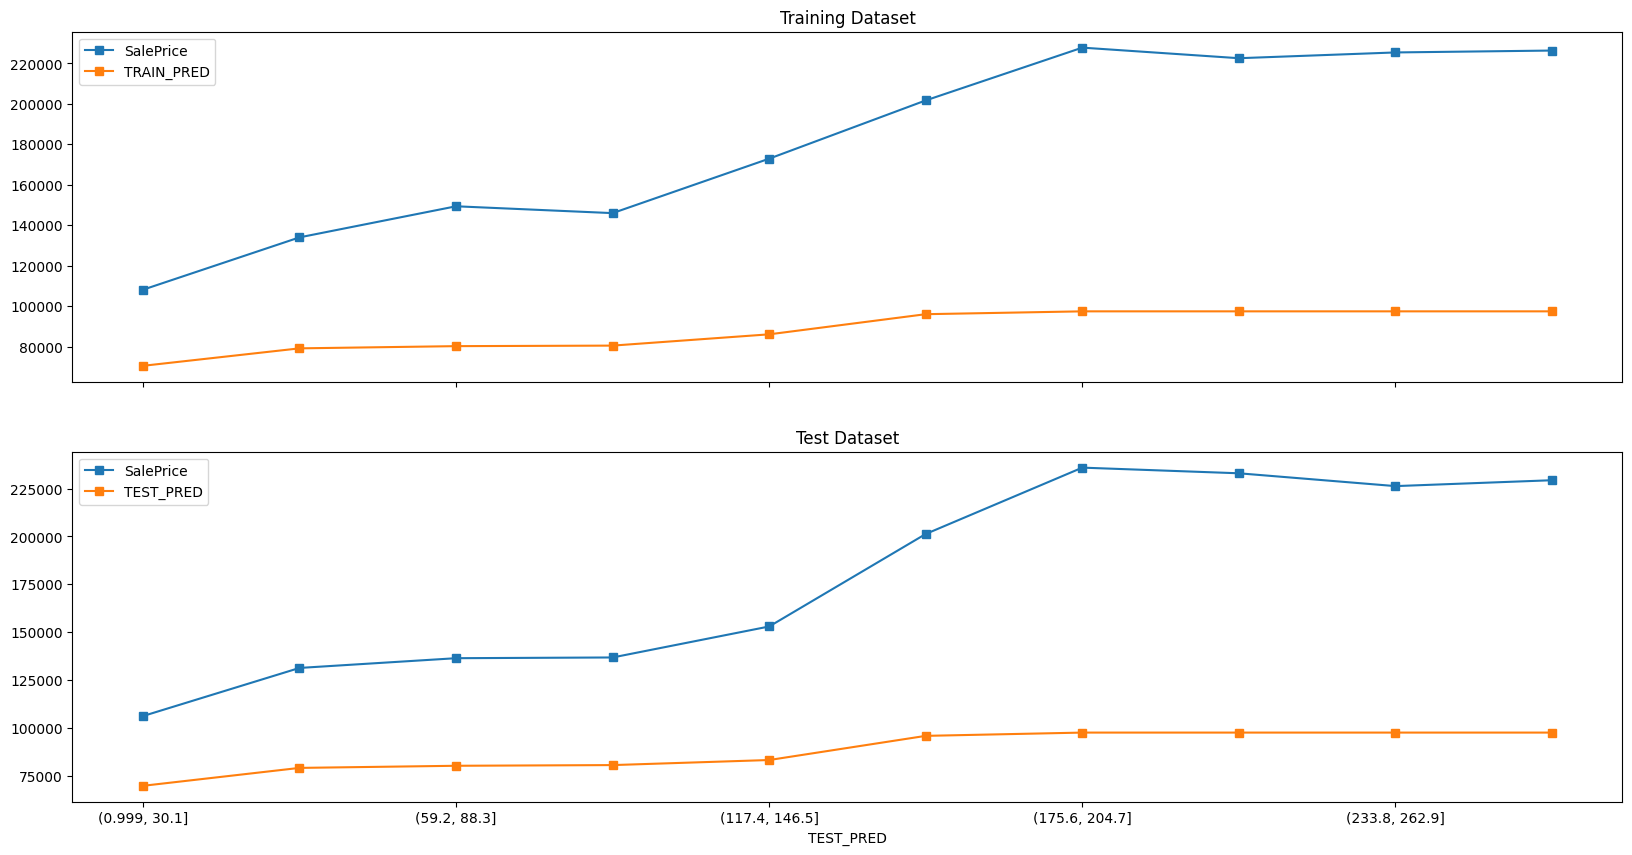

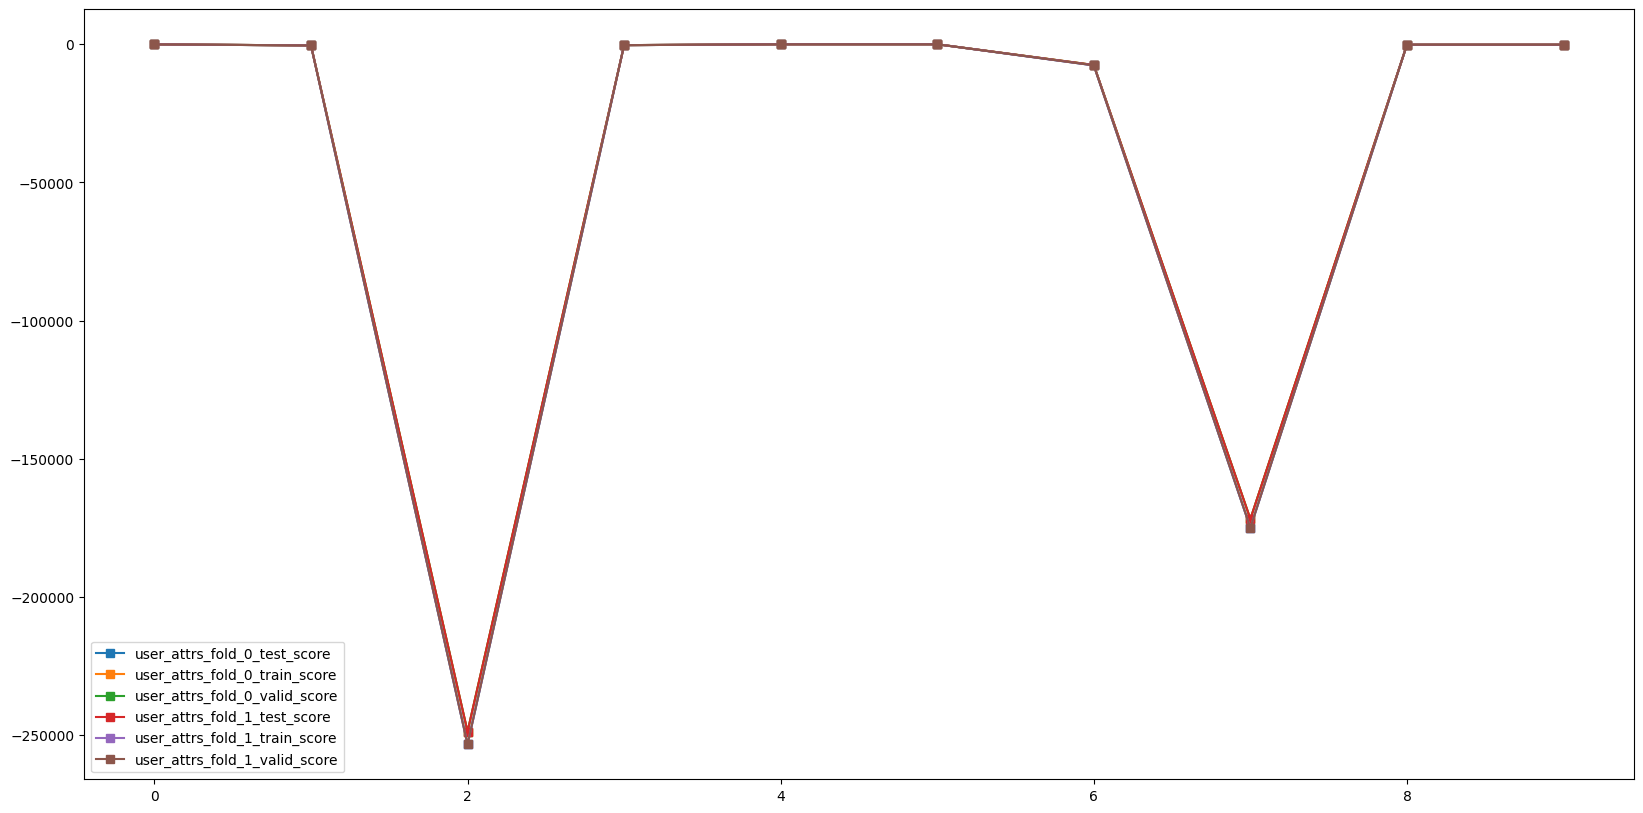


PREDICTED DISTRIBUTION


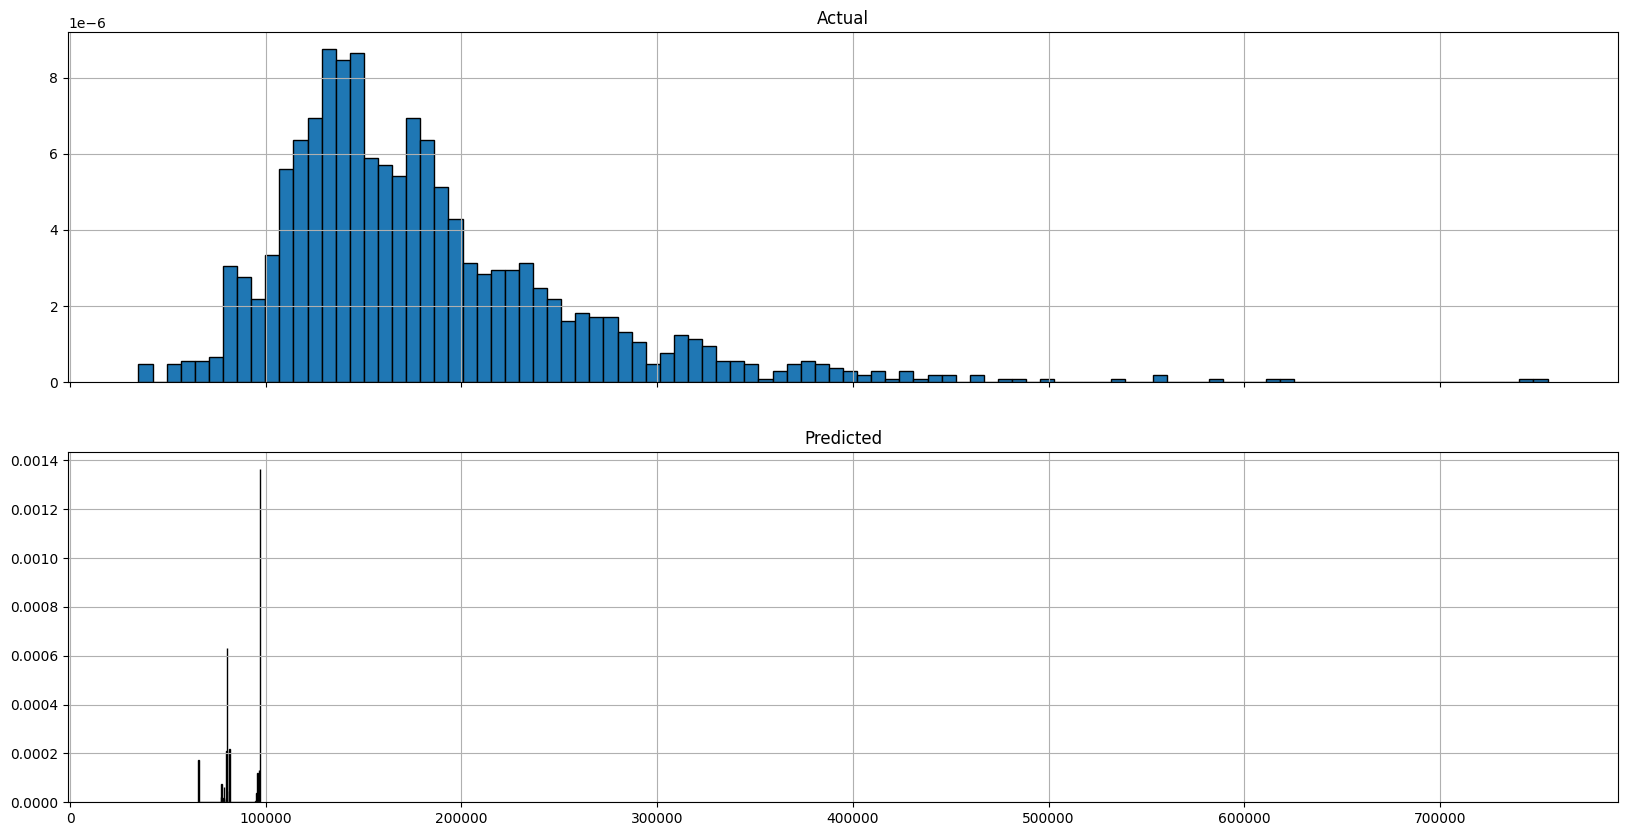


MEDIAN SALE PRICES


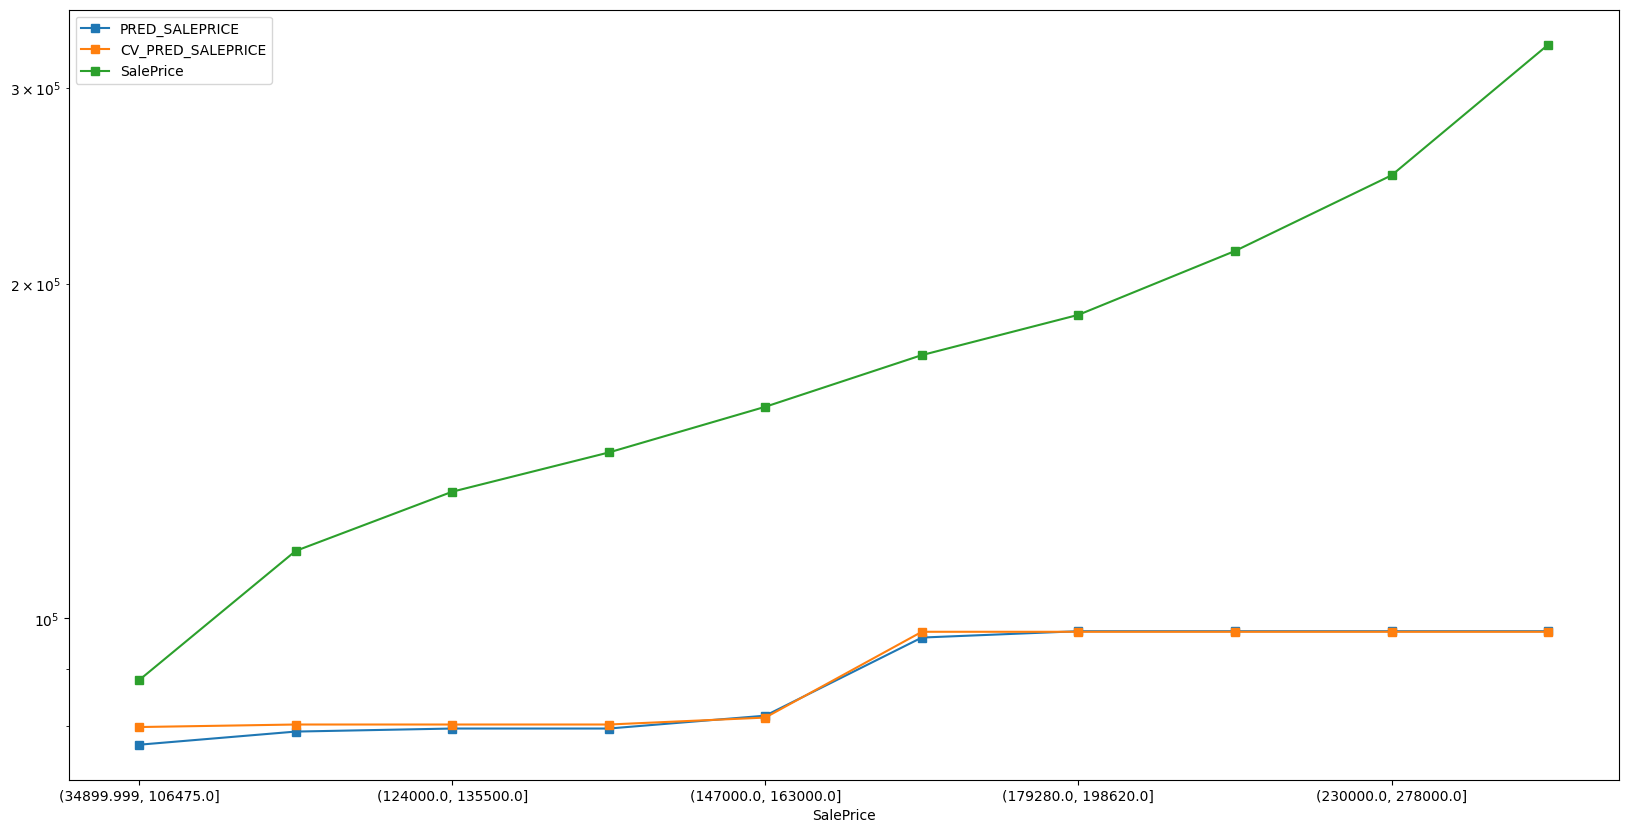


FEATURE IMPORTANCES AND DEPENDENCE PLOTS


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


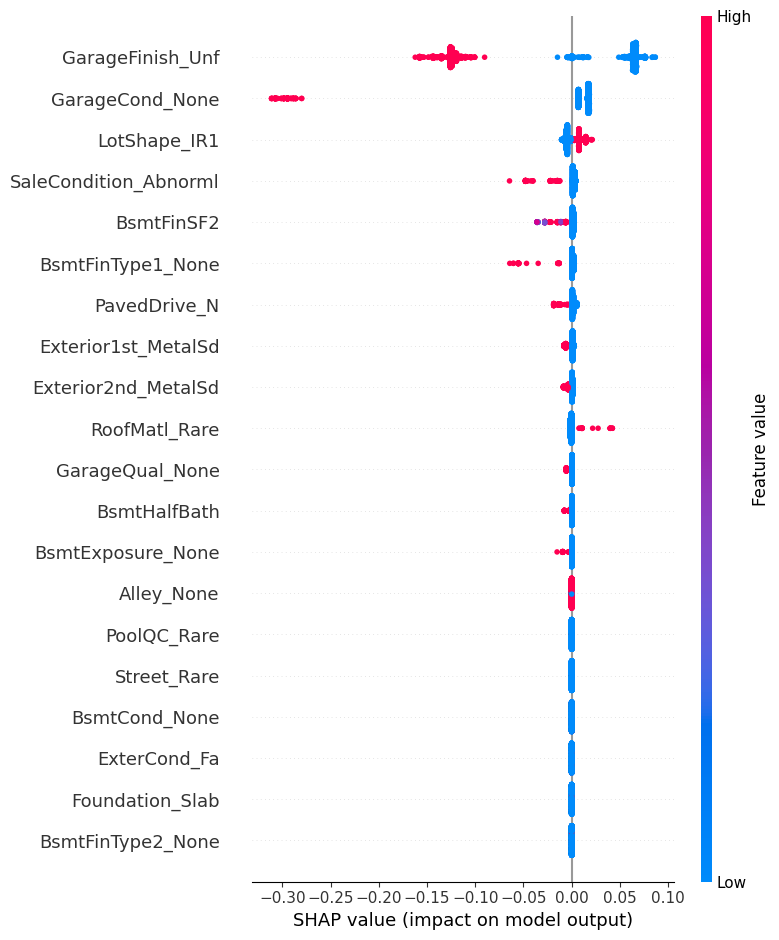

invalid value encountered in divide
invalid value encountered in divide


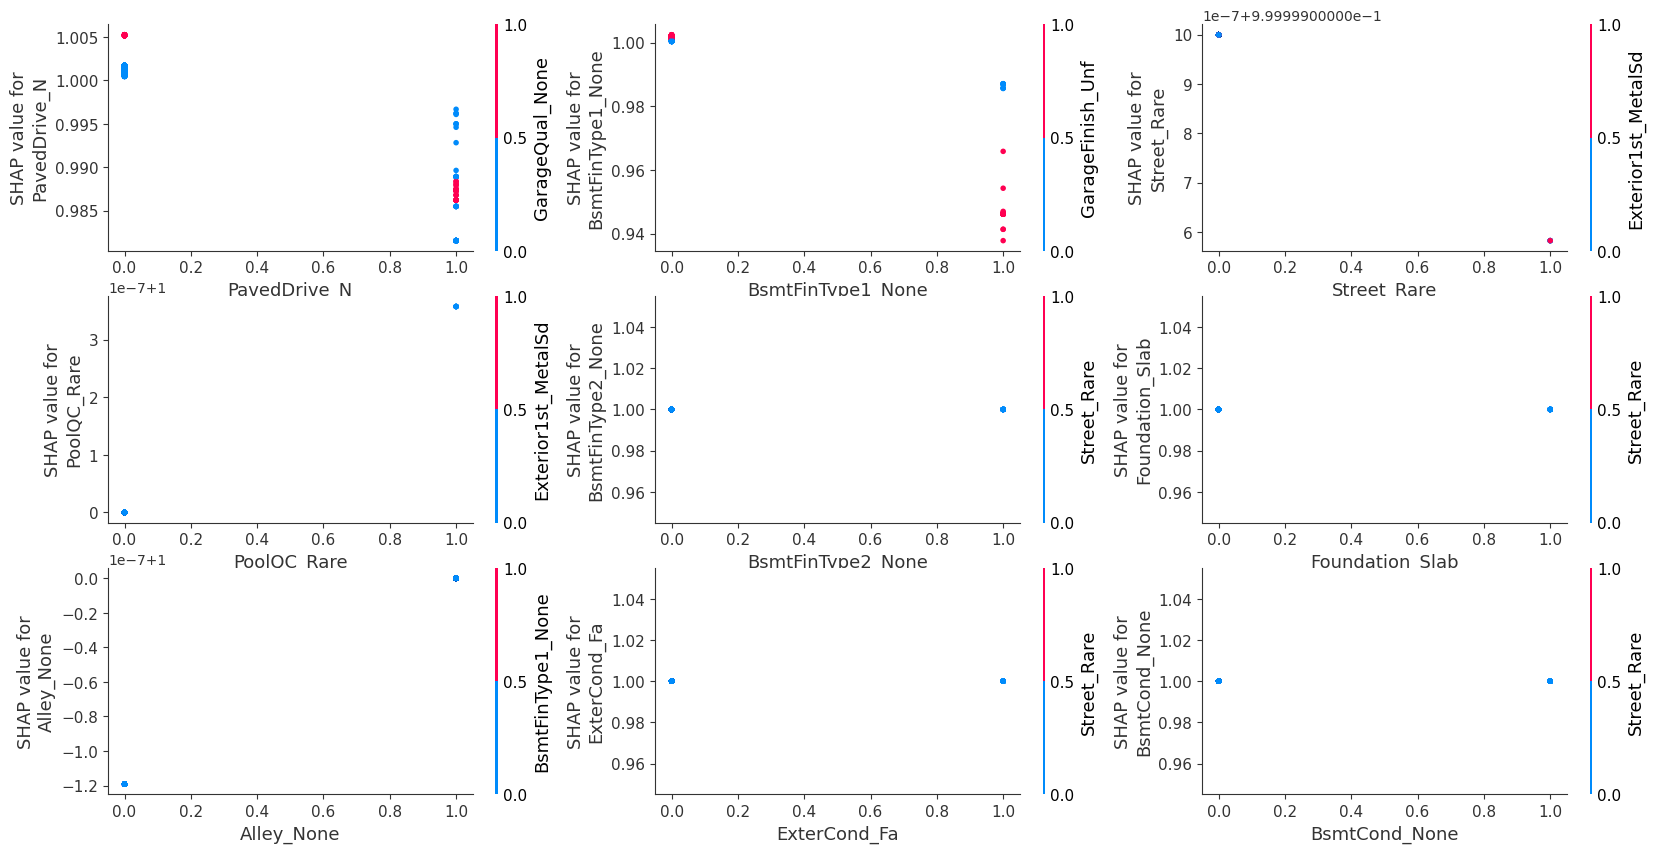

In [3]:
model.train()

In [4]:
model.results_dict

{'train_neg_mean_gamma_deviance': array([-0.79667129, -0.74360237, -0.72474597]),
 'test_neg_mean_gamma_deviance': [-0.7591800547950263,
  -0.8220927466142173,
  -0.6937566157580801],
 'train_r2': array([-1.36654565, -1.16871861, -1.50907437]),
 'test_r2': [-1.035071000958331, -0.7903675058261561, -1.2151382362363932],
 'actual': [array([154500, 325000, 115000, 159000, 315500,  75500, 311500, 146000,
          84500, 135500, 145000, 130000,  81000, 214000, 181000, 134500,
         183500, 135000, 118400, 226000, 155000, 210000, 173500, 129000,
         192000, 153900, 181134, 141000, 181000, 208900, 127000, 284000,
         200500, 135750, 255000, 140000, 138000, 219500, 310000,  97000,
         114500, 205000, 119500, 253293, 128500, 117500, 115000, 127000,
         451950, 144000, 119000, 196000, 115000, 287000, 144500, 260000,
         213000, 175000, 107000, 107500,  68500, 154000, 317000, 264132,
         283463, 243000, 109000, 305000,  93500, 176000, 118858, 134000,
         109

In [6]:
import pickle
with open('test.pkl', 'wb') as file:  
    pickle.dump(model, file)

In [7]:
with open('test.pkl', 'rb') as file:  
    test = pickle.load(file)

## Deploy the Model

In [8]:
@component(
    #packages_to_install=["google-cloud-aiplatform", "sklearn",  "kfp"],
    #base_image="europe-west1-docker.pkg.dev/PROJECT_ID/wine-train/scikit-learn-winequality:latest",
    base_image=BASE_IMAGE,
    output_component_file="model_deployment.yaml"
)

def deploy_houseprice(
    model: Input[Model],
    project: str,
    region: str,
    serving_container_image_uri : str, 
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)

    DISPLAY_NAME  = "houseprice"
    MODEL_NAME = "houseprice-xgboost"
    ENDPOINT_NAME = "houseprice_endpoint"
    
    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=project, 
        location=region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=project, location=region
        )
    endpoint = create_endpoint()   
    
    
    # Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = DISPLAY_NAME, 
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri = serving_container_image_uri,
        serving_container_health_route = f"/v1/models/{MODEL_NAME}",
        serving_container_predict_route = f"/v1/models/{MODEL_NAME}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": MODEL_NAME,
    },       
    )
    
    model_deploy = model_upload.deploy(
        machine_type="n1-standard-4", 
        endpoint=endpoint,
        traffic_split={"0": 100},
        deployed_model_display_name=DISPLAY_NAME,
    )

    # Save data to the output params
    vertex_model.uri = model_deploy.resource_name


## Create the Pipeline

In [9]:
# USE TIMESTAMP TO DEFINE UNIQUE PIPELINE NAMES
TIMESTAMP =datetime.now().strftime("%Y%m%d%H%M%S")
DISPLAY_NAME = 'pipeline-test-job{}'.format(TIMESTAMP)

PROJECT_ID = 'gb-lab-us-binders-15'
REGION = 'europe-west2'

In [10]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="pipeline-test",
    
)

def pipeline(
    data_filepath: str = f"{BUCKET_NAME}/Data",
    project: str = PROJECT_ID,
    region: str = REGION, 
    display_name: str = DISPLAY_NAME,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    thresholds_dict: dict = '{"r2_score":0.8}',
    serving_container_image_uri: str = "europe-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest"
    ):
    
    data_op = get_houseprice_data(data_filepath)
    feat_eng_select_op = feat_engineering_and_selection(data_op.outputs["dataset_train"], data_op.outputs["dataset_valid"], data_op.outputs["dataset_test"])
    train_model_op = train_houseprice(feat_eng_select_op.outputs["train_feat_eng_df"], feat_eng_select_op.outputs["valid_feat_eng_df"], feat_eng_select_op.outputs["test_feat_eng_df"])
    model_evaluation_op = evaluate_houseprice(
        houseprice_model = train_model_op.outputs["model"],
        thresholds_dict = thresholds_dict, # the model is deployed anly if the model performance is above the threshold
    )
    
    # Use conditional pipeline feature to execute deploy_model_op only when the model score is better than threshold
    with dsl.Condition(
        model_evaluation_op.outputs["deploy"]=="true",
        name="deploy-houseprice",
    ):
           
        deploy_model_op = deploy_houseprice(
        model = train_model_op.outputs['model'],
        project = project,
        region = region, 
        serving_container_image_uri = serving_container_image_uri,
        )

## Compile and Run the Pipeline

In [11]:
# COMPILE THE PIPELINE (to create the job spec file)

compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='ml_houseprice.json')

/home/jupyter/virtualenvironment/vertex_env/lib/python3.8/site-packages/kfp/v2/compiler/compiler.py:1290: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  warnings.warn(


In [12]:
# CREATE A RUN USING THE JOB SPEC FILE GENERATED 

start_pipeline = pipeline_jobs.PipelineJob(
    display_name="test-pipeline",
    template_path="ml_houseprice.json",
    enable_caching=False,
    location=REGION,
)

In [13]:
# RUN THE PIPELINE

start_pipeline.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/164485752674/locations/europe-west2/pipelineJobs/pipeline-test-20221013163239
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/164485752674/locations/europe-west2/pipelineJobs/pipeline-test-20221013163239')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west2/pipelines/runs/pipeline-test-20221013163239?project=164485752674
PipelineJob projects/164485752674/locations/europe-west2/pipelineJobs/pipeline-test-20221013163239 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/164485752674/locations/europe-west2/pipelineJobs/pipeline-test-20221013163239 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/164485752674/locations/europe-west2/pipelineJobs/pipeline-test-20221013163239 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/164485752674/locations/europe-west2/pipelineJobs/pipelin

KeyboardInterrupt: 

## List All Models

In [26]:
DISPLAY_NAME = "houseprice"
! gcloud ai models list --region={REGION} --filter={DISPLAY_NAME}

Using endpoint [https://europe-west2-aiplatform.googleapis.com/]
Listed 0 items.


## Trigger the Pipeline

### Schedule the Pipeline

The scheduled pipelines are supported by Cloud Scheduler and Cloud Functions. Check that APIs Cloud Scheduler and Cloud Functions are enabled.

### Run Recurrent Pipeline

In [ ]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
                project_id=PROJECT_ID,
                region=REGION,
                )

SERVICE_ACCOUNT = (
    "XXXXXX@developer.gserviceaccount.com" # Replace the Xs with your generated service-account.
)

response = api_client.create_schedule_from_job_spec(
    enable_caching=True,
    job_spec_path="ml_houseprice.json",
    schedule="0 0 * * 1", # once per week on Monday (use schedule parameter to mention the recurrence interval)
    time_zone="Europe/London",  # change this as necessary
    parameter_values={"display_name": DISPLAY_NAME},
    pipeline_root=PIPELINE_ROOT,  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    #service_account=SERVICE_ACCOUNT,  
)

## Simulate Batch Predictions and Real-Time Predictions

### Test the Batch Prediction

In [ ]:
# Define variables 
job_display_name = "test-houseprice-batch-prediction-job"
MODEL_NAME="houseprice"
ENDPOINT_NAME="houseprice_endpoint"  # endpoint where the model is deployed
BUCKET_URI="gs://your-bucket-houseprice/pipeline_root_houseprice/332188XXXX/pipeline-houseprice-20211227155508/get-houseprice-data_8271177375014715392" # bucket containing batch instances ready for prediction
input_file_name="test.csv"

# Get model id
MODEL_ID=!(gcloud ai models list --region=$REGION \
           --filter=display_name=$MODEL_NAME)  # ids of the prediction/uploaded models
MODEL_ID=MODEL_ID[2].split(" ")[0]  # we use the latest uploaded model

model_resource_name = f'projects/{PROJECT_ID}/locations/{REGION}/models/{MODEL_ID}'
gcs_source= [f"{BUCKET_URI}/{input_file_name}"]
gcs_destination_prefix=f"{BUCKET_URI}/output" # google storage destination where we save the prediction output

def batch_prediction_job(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source: str,
    gcs_destination_prefix: str,
    machine_type: str,
    starting_replica_count: int = 1, # The number of nodes for this batch prediction job. 
    max_replica_count: int = 1,    
):   
    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_resource_name)

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        instances_format='csv', #json
        gcs_source=[f"{BUCKET_URI}/{input_file_name}"],
        gcs_destination_prefix=f"{BUCKET_URI}/output",
        machine_type=machine_type, # must be present      
    )
    batch_prediction_job.wait()
    print(batch_prediction_job.display_name)
    print(batch_prediction_job.state)
    return batch_prediction_job

batch_prediction_job(PROJECT_ID, REGION, model_resource_name, job_display_name, gcs_source, gcs_destination_prefix, machine_type="n1-standard-2")

### Send an Online Prediction Request

Each prediction request must be max. 1.5 MB.

In [ ]:
ENDPOINT_NAME="houseprice_endpoint"
instance = [[1,2,3,2,1,2,3,6,7,10]]  # input data to make prediction on
ENDPOINT_ID = !(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)'\
              --filter=display_name=$ENDPOINT_NAME \
              --sort-by=creationTimeStamp | tail -1)
ENDPOINT_ID = ENDPOINT_ID[1]

def endpoint_predict(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    return prediction

endpoint_predict(PROJECT_ID, REGION, instance, ENDPOINT_ID)